# Previsão de Faturamento - Soma de previsões de produtos modelados individualmente.

<sub>Projeto para a disciplina de **Estatística** (Módulo 4) do Data Science Degree (turma de julho de 2020)</sub>

## Equipe

* Felipe Lima de Oliveira
* Mário Henrique Romagna Cesa
* Tsuyioshi Valentim Fukuda
* Fernando Raineri Monari

Link para [projeto no Github](https://github.com/flimao/case-previsao-faturamento)

## Introdução

Este notebook contém o modelo ajustado para o faturamento total mês a mês, somando cada modelo de cada produto

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# modelos
from pmdarima.arima import auto_arima
from pmdarima.arima.arima import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# metricas 
from sklearn.metrics import mean_absolute_percentage_error as smape, mean_squared_error as smse, mean_absolute_error as smae 

# importar scripts
cwd = os.getcwd()
os.chdir("../")
import py_scripts.plots, py_scripts.transform, py_scripts.metrics

os.chdir(cwd)

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = (10, 4)

## Importação dos dados

In [4]:
ts_raw = pd.read_csv(r'../data/sim_ts_limpo.csv')
tsd, tswide = py_scripts.transform.pipeline(ts_raw)

produtos = tswide.columns
n_produtos = produtos.shape[0]

## Set-up - Acumuladores

In [5]:
arimas = {}
metricas = {}

## Faturamento do produto `alimenticio`

Notebook: [`produto_alimenticio_arima.ipynb`](./produto_alimenticio_arima.ipynb)

In [6]:
analise_produto = 'alimenticio'
fat = tswide['alimenticio'].dropna()

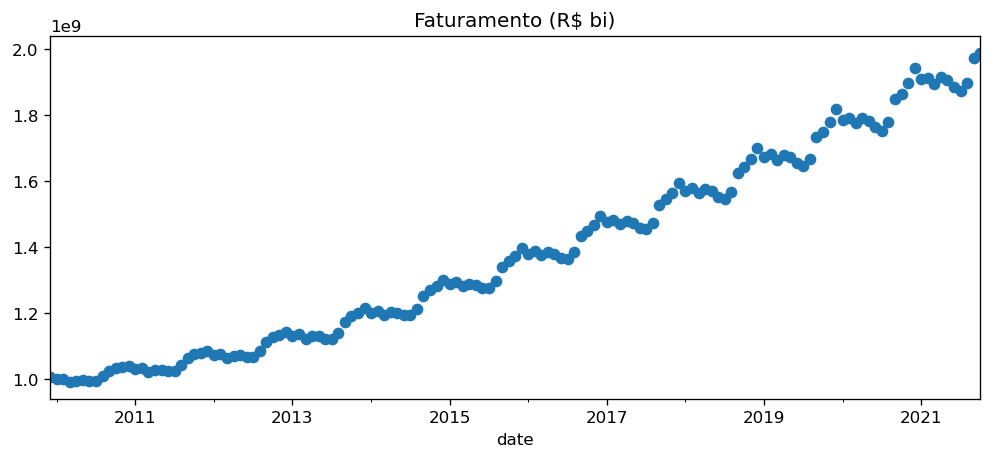

In [7]:
fat.plot(linestyle = '', marker = 'o')
plt.title('Faturamento (R$ bi)')
plt.show()

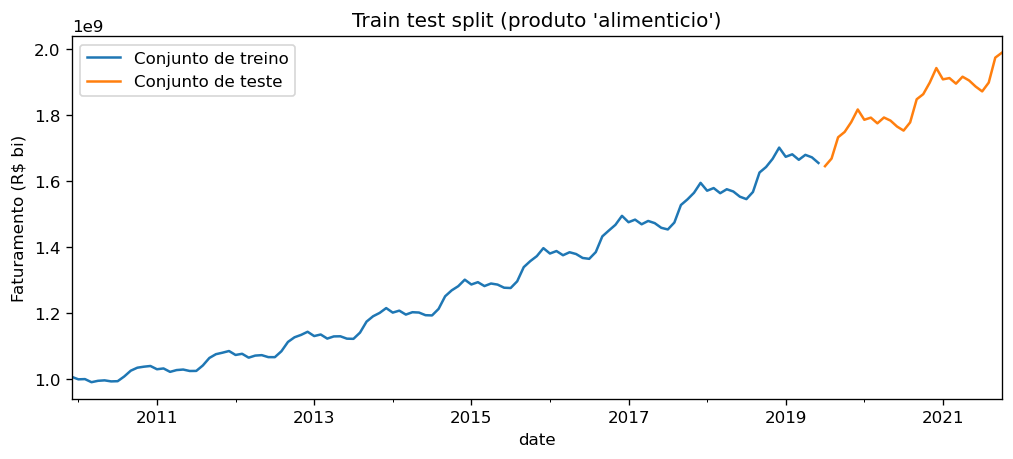

In [8]:
test_begin = '2019-01-01'
fat_train = fat[:test_begin].iloc[:-1]
fat_test = fat[test_begin:]

train_test_split_idx = int(fat.shape[0] * 0.8 + 1)
fat_train = fat[:train_test_split_idx]
fat_test = fat[train_test_split_idx:]

fat_train.plot(label = 'Conjunto de treino')
fat_test.plot(label = 'Conjunto de teste')
plt.title(f"Train test split (produto '{analise_produto}')")
plt.ylabel('Faturamento (R$ bi)')
plt.legend()
plt.show()

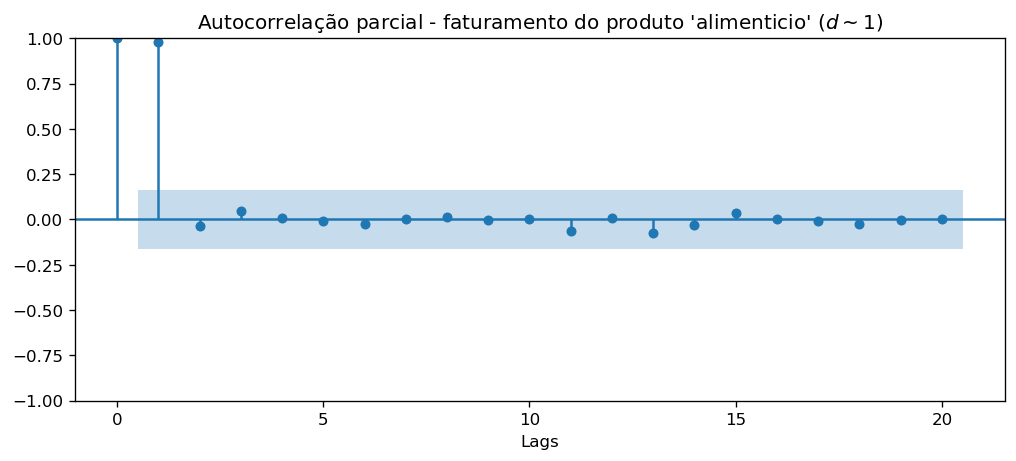

In [9]:
fig = plt.figure()
ax = fig.gca()
plot_pacf(fat, lags = 20, method = 'ywm', ax = ax)
ax.set_xlabel('Lags')
ax.set_title(f"Autocorrelação parcial - faturamento do produto '{analise_produto}' ($d \sim 1$)")
plt.show()

O melhor ajuste foi obtido em [notebook próprio](./3-faturamento_alimenticio_ts.ipynb):

In [10]:
arimas[analise_produto] = ARIMA(order = (1, 2, 0), seasonal_order = (0, 2, 0, 12), with_intercept = False).fit(y = fat_train)

In [11]:
arimas[analise_produto].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  115
Model:             SARIMAX(1, 2, 0)x(0, 2, 0, 12)   Log Likelihood               -1329.655
Date:                            Wed, 17 Nov 2021   AIC                           2663.310
Time:                                    14:31:46   BIC                           2668.287
Sample:                                         0   HQIC                          2665.316
                                            - 115                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0009      0.045      0.020      0.984      -0.087       0.089
sigma2      5.075e+11   5.86e-15   8.66e+25      0.000    5.08e+11    5.08e+11
===================================================================================
Ljung-Box (L1) (Q):                   8.38   Jarque-Bera (JB):                 2.10
Prob(Q):                              0.00   Prob(JB):                         0.35
Heteroskedasticity (H):               1.96   Skew:                             0.28
Prob(H) (two-sided):                  0.07   Kurtosis:                         2.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.11e+42. Standard errors may be unstable.
"""

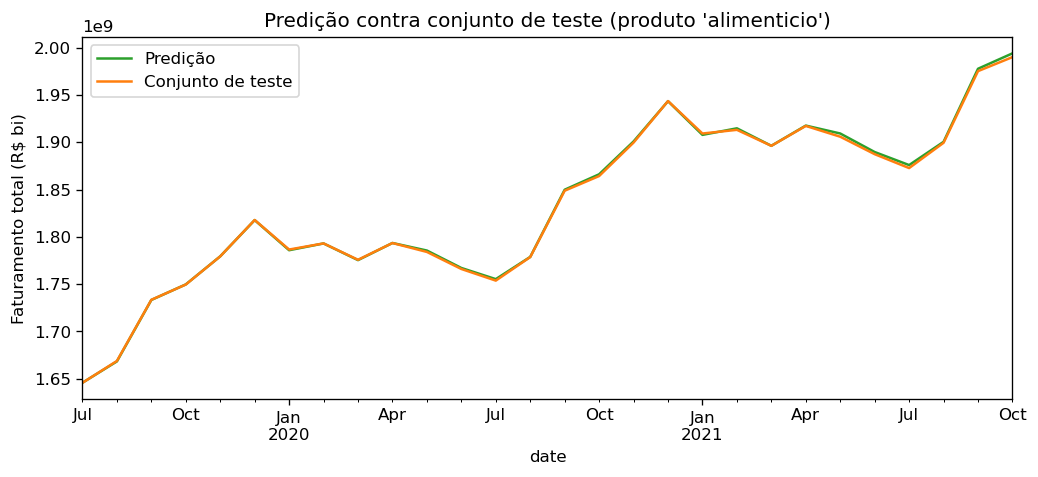

In [13]:
n_test_periods = fat_test.shape[0]
arr_preds = arimas[analise_produto].predict(n_test_periods)

idx = pd.date_range(freq = 'MS', start = fat_test.index[0], periods = n_test_periods)
preds = pd.Series(arr_preds, index = idx)
preds.name = 'yearly_preds'

palette = sns.color_palette(None, 4)
preds.plot(label = 'Predição', color = palette[2])
fat_test.plot(label = 'Conjunto de teste', color = palette[1])

plt.legend()
plt.ylabel('Faturamento total (R$ bi)')
plt.title(f"Predição contra conjunto de teste (produto '{analise_produto}')")
plt.show()

### Métricas

In [14]:
kwargs_ajuste = dict(
    y_true = fat_test,
    y_pred = preds,
    n = fat_train.shape[0],
    dof = arimas[analise_produto].df_model()
)

py_scripts.metrics.mostrar_metricas(**kwargs_ajuste)

Métricas:
    MAPE: 0.058%
    RMSE: 1.553e+06
     MAE: 1.087e+06
      R²: 99.967%
 R² adj.: 99.967%
